# Case Studi : Klasifikasi Review Produk Berdasarkan Rating

Langkah-langkah penyelesaian melitputi:

1. Data collection
2. Pre-processing
    1. Case Folding
    2. Filtering
    3. Stopword
    4. Stemming
3. Feature Extraction
    1. TF-IDF
4. Feature Selection
    1. Chi-Square

Pada kasus ini, dataset yang digunakan adalah dataset berbahasa indonesia, sehingga dibutuhkan Library Sastrawi untuk menyelesaikan beberapa permasalahan seperti stemming.

## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [ ]:
!pip -q install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


## Data Acquisition

In [ ]:
df = pd.read_csv("dataset_review.csv")
df.head()

,Unnamed: 0,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,9-Apr-19,androidApp,10/2/2019
1,1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24-Sep-17,androidApp,10/2/2019
2,2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood,0,0,0,True,21.50,4-Apr-18,androidApp,10/2/2019
3,3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22-Sep-17,androidApp,10/2/2019
4,7,100002528,beli-harddisk-eksternal,nurfarida,1,NaN,ada pengirimn ntb bima,bima,4,4,0,True,7.22,NaN,androidApp,10/2/2019


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107029 entries, 0 to 107028
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      107029 non-null  int64  
 1   itemId          107029 non-null  int64  
 2   category        107029 non-null  object 
 3   name            107029 non-null  object 
 4   rating          107029 non-null  int64  
 5   originalRating  8 non-null       float64
 6   reviewTitle     21073 non-null   object 
 7   reviewContent   107029 non-null  object 
 8   likeCount       107029 non-null  int64  
 9   upVotes         107029 non-null  int64  
 10  downVotes       107029 non-null  int64  
 11  helpful         107029 non-null  bool   
 12  relevanceScore  107029 non-null  float64
 13  boughtDate      100564 non-null  object 
 14  clientType      107029 non-null  object 
 15  retrievedDate   107029 non-null  object 
dtypes: bool(1), float64(2), int64(6), object(7)
memory usage

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
itemId,0
category,0
name,0
rating,0
originalRating,107021
reviewTitle,85956
reviewContent,0
likeCount,0
upVotes,0


In [ ]:
df['category'].value_counts()

,count
category,
beli-harddisk-eksternal,42039
jual-flash-drives,32738
beli-smart-tv,17233
shop-televisi-digital,11934
beli-laptop,3085


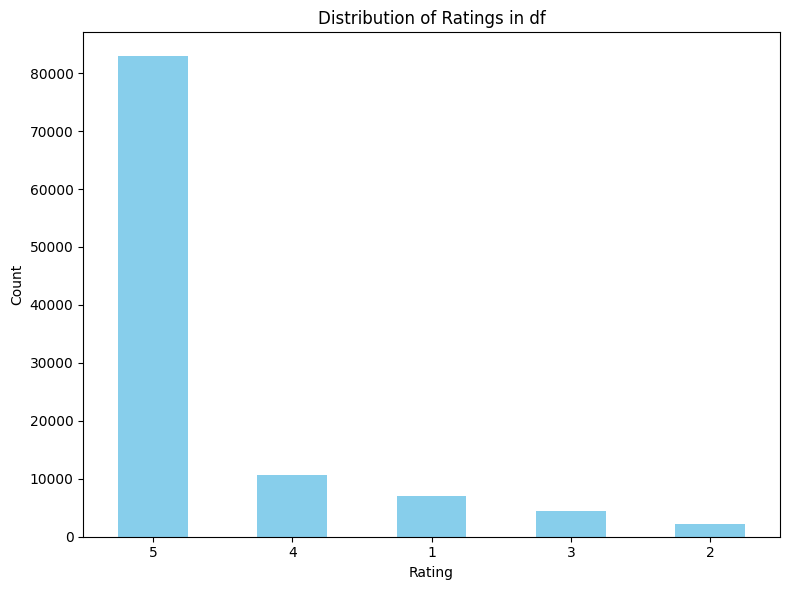

In [ ]:
# Count rating frequencies
rating_counts = df['rating'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in df')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
df.iloc[:, [4, 7]]

,rating,reviewContent
0,5,bagus mantap dah sesui pesanan
1,4,"Bagus, sesuai foto"
2,5,okkkkk mantaaaaaaapppp ... goood
3,4,bagus sesuai
4,1,bima
...,...,...
107024,5,Wkwkwk
107025,1,seller incapable to keep his product page clea...
107026,5,barang bagus dengan harga kompetitif
107027,3,Ok.thank lazada Pagi order sore barang nyampe ...


## Text Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Case Folding

In [ ]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
    text = text.lower()                               # Mengubah teks menjadi lower case
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
    text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
    text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
    text = text.strip()
    return text

### Word Normalization

In [ ]:
# Download corpus singkatan
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2024-08-07 18:48:05--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.03s   

2024-08-07 18:48:05 (2.52 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [ ]:
key_norm = pd.read_csv('https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv')

def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
    text = str.lower(text)
    return text

### Filtering (Stopword Removal)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [ ]:
len(stopwords_ind)

758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [ ]:
def remove_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)

### Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

### Text Preprocessing Pipeline

In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
df['reviewContent'] = df['reviewContent'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 1h 17min 19s, sys: 25.3 s, total: 1h 17min 44s
Wall time: 1h 18min 19s


In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
df.to_csv('clean_data.csv')

## Feature Engineering

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("clean_data.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,0,0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap sesui pesan,0,0,0,True,26.51,9-Apr-19,androidApp,10/2/2019
1,1,1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,bagus sesuai foto,0,0,0,True,22.49,24-Sep-17,androidApp,10/2/2019
2,2,2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp goood,0,0,0,True,21.50,4-Apr-18,androidApp,10/2/2019
3,3,3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22-Sep-17,androidApp,10/2/2019
4,4,7,100002528,beli-harddisk-eksternal,nurfarida,1,NaN,ada pengirimn ntb bima,bima,4,4,0,True,7.22,NaN,androidApp,10/2/2019


In [ ]:
# Pisahkan kolom feature dan target
X = df['reviewContent']
y = df['rating']

In [ ]:
X

,reviewContent
0,bagus mantap sesui pesan
1,bagus sesuai foto
2,okkkkk mantaaaaaaapppp goood
3,bagus sesuai
4,bima
...,...
107024,wkwkwk
107025,jual incapable keep his produk page clear the ...
107026,barang bagus harga kompetitif
107027,okthank lazada pagi order sore barang packing ...


In [ ]:
y

,rating
0,5
1,4
2,5
3,4
4,1
...,...
107024,5
107025,1
107026,5
107027,3


### Feature Extraction (TF-IDF and N-gram

In [ ]:
#save model
import pickle

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Unigram
vec_TF_IDF = TfidfVectorizer(ngram_range=(1,1))

# Handle missing values in 'reviewContent' column before fitting
X_cleaned = X.fillna('')  # Replace NaN values with empty strings
vec_TF_IDF.fit(X_cleaned)  # Fit the vectorizer on the cleaned data

x_tf_idf = vec_TF_IDF.transform(X_cleaned)

#Save vectorizer.vocabulary_
pickle.dump(vec_TF_IDF.vocabulary_,open("feature_tf-idf.pkl","wb"))

In [ ]:
#Menampilkan vocabulary dari TF-IDF
vec_TF_IDF.vocabulary_

{'bagus': 1319,
 'mantap': 12929,
 'sesui': 20259,
 'pesan': 16909,
 'sesuai': 20208,
 'foto': 7353,
 'okkkkk': 15613,
 'mantaaaaaaapppp': 12790,
 'goood': 8098,
 'bima': 2916,
 'layar': 11808,
 'gar': 7667,
 'rabu': 17932,
 'soreminggu': 20896,
 'sore': 20889,
 'sampebarang': 19164,
 'specs': 20958,
 'mantabtks': 12907,
 'lazada': 11828,
 'cicil': 4331,
 'pakai': 16146,
 'yacc': 23785,
 'televisi': 21750,
 'suda': 21208,
 'anti': 805,
 'gores': 8113,
 'kirim': 10819,
 'barang': 2068,
 'janji': 9372,
 'express': 6969,
 'jumat': 9812,
 'moga': 14073,
 'awet': 1117,
 'kualitas': 11232,
 'ok': 15438,
 'led': 12109,
 'merek': 13758,
 'sharp': 20326,
 'hitam': 8697,
 'lc': 12054,
 'lei': 12131,
 'mati': 13355,
 'total': 22518,
 'mana': 12724,
 'hubung': 8814,
 'bantu': 2031,
 'mohon': 14077,
 'bijak': 2898,
 'solusi': 20854,
 'garansi': 7670,
 'terimakasih': 21918,
 'super': 21328,
 'sich': 20405,
 'tahan': 21481,
 'cra': 4709,
 'nya': 15031,
 'cepat': 4012,
 'sipplahhh': 20562,
 'ne': 1450

In [ ]:
#Melihat Jumlah Fitur
print (len(vec_TF_IDF.get_feature_names_out()))

24018


In [ ]:
#Melihat fitur-fitur apa saja yang ada di dalam corpus kita
print(vec_TF_IDF.get_feature_names_out())

['aa' 'aaa' 'aaaaaaaasika' ... 'zuma' 'zuper' 'zzz']


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Handle missing values
X_cleaned = X.fillna('')

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_cleaned)

# Optional: Reduce dimensionality using Truncated SVD
svd = TruncatedSVD(n_components=1000)  # Adjust n_components as needed
X_tfidf_reduced = svd.fit_transform(X_tfidf)

# Convert to DataFrame for convenience (optional)
data_tabular_tf_idf = pd.DataFrame(X_tfidf_reduced, columns=[f'component_{i}' for i in range(1000)])

print(data_tabular_tf_idf.shape)



(107029, 1000)


In [ ]:
data_tabular_tf_idf.iloc[10:20,60:70]

,component_60,component_61,component_62,component_63,component_64,component_65,component_66,component_67,component_68,component_69
10,0.001649,-0.008678,-0.005163,-0.003029,-0.003117,0.006005,-0.010951,-0.002529,0.003772,-0.010845
11,0.015038,0.000546,0.010379,-0.008365,-0.002033,-0.005992,0.006166,-0.003779,-0.006242,-0.001543
12,0.000392,0.016000,0.003763,0.000111,0.011166,0.023955,-0.014540,0.017213,0.009307,0.004255
13,0.012601,0.016235,0.016979,-0.006248,0.000463,-0.016977,-0.000922,0.030980,-0.009749,0.014184
14,-0.001724,0.001888,-0.006963,0.004875,-0.001030,0.004621,-0.008307,-0.001665,0.001814,-0.012381
15,0.009604,0.002519,0.016418,-0.014132,-0.001177,-0.018254,0.007127,-0.013417,0.000160,0.001407
16,-0.005270,-0.001072,-0.007646,0.001015,0.000879,0.001096,0.002949,-0.004747,0.001760,-0.002826
17,0.261272,0.101435,-0.139343,-0.140807,-0.097280,-0.026260,0.016327,-0.058322,0.025156,-0.032100
18,-0.031602,0.002534,-0.055491,0.007279,-0.018773,0.024172,-0.001097,-0.010957,0.001895,0.010226
19,0.118210,0.042118,-0.068402,-0.064909,-0.070920,-0.013331,0.026983,-0.012867,0.019812,-0.023618


### Feature Selection

In [ ]:
#Mengubah nilai data tabular tf-idf & y dari dataframe menjdi array agar dapat dijalankan pada proses seleksi fitur
x_train = np.array(data_tabular_tf_idf)
y_train = np.array(y)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np  # for log transformation

# ... (your previous code)

# Check data type and presence of negative values
print(type(X_tfidf_reduced))
print(X_tfidf_reduced.dtype)
print(np.any(X_tfidf_reduced < 0))

# Handle potential numerical precision issues
X_tfidf_reduced[X_tfidf_reduced < 1e-10] = 0

# Option 1: Using chi2 with adjusted values
chi2_features = SelectKBest(chi2, k=1000)
X_kbest_features = chi2_features.fit_transform(X_tfidf_reduced, y_train)

# Option 2: Using mutual_info_classif (alternative)
# mutual_info_features = SelectKBest(mutual_info_classif, k=1000)
# X_kbest_features_mi = mutual_info_features.fit_transform(X_tfidf_reduced, y_train)


# Option 3: Consider alternative statistics (e.g., mutual_info_classif)

print('Original feature number:', X_tfidf_reduced.shape[1])
print('Selected feature number:', X_kbest_features.shape[1])


<class 'numpy.ndarray'>
float64
True
Original feature number: 1000
Selected feature number: 1000


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data =pd.DataFrame(chi2_features.scores_,columns=['Nilai'])
data

,Nilai
0,541.026262
1,238.712987
2,496.338418
3,88.225959
4,107.411576
...,...
995,8.877547
996,8.580589
997,7.969703
998,6.944930


In [ ]:
#Menampilkan fitur beserta nilainya
feature =vec_TF_IDF.get_feature_names_out()
feature

# Assuming chi2_features is fitted
data['Fitur'] = chi2_features.get_feature_names_out()

In [ ]:
#Mengurutkan fitur terbaik
data.sort_values(by='Nilai', ascending=False)

,Nilai,Fitur
0,541.026262,x0
2,496.338418,x2
58,374.588061,x58
1,238.712987,x1
18,204.328624,x18
...,...,...
168,0.282174,x168
165,0.255767,x165
166,0.244944,x166
233,0.188130,x233


In [ ]:
#Menampilkan mask pada feature yang diseleksi
#False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask =chi2_features.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
#Menampilkan fitur-fitur terpilih berdasarkan nilai mask atau nila tertinggi yang sudah ditetapkan pada Chi-Square
new_feature=[]
for bool,f in zip(mask,feature):
    if bool:
        new_feature.append(f)
    selected_feature=new_feature
selected_feature

['aa',
 'aaa',
 'aaaaaaaasika',
 'aaaaassppp',
 'aaaakena',
 'aaahhhh',
 'aaamiiiin',
 'aaamiiin',
 'aaamiin',
 'aaamin',
 'aaammppuuuunnn',
 'aac',
 'aada',
 'aalaupun',
 'aaman',
 'aamantank',
 'aamiiin',
 'aamiin',
 'aamiinn',
 'aamiinsukses',
 'aaminn',
 'aampai',
 'aapalagi',
 'aazzziibbb',
 'ab',
 'ababila',
 'abadi',
 'abai',
 'abal',
 'abalabal',
 'abalan',
 'abalgood',
 'abang',
 'abc',
 'abg',
 'abid',
 'abidin',
 'abieezz',
 'abies',
 'abiezzz',
 'abiiisss',
 'abiis',
 'abiiss',
 'abil',
 'abis',
 'abisandroid',
 'abisfitur',
 'abispengiriman',
 'abiss',
 'abissee',
 'abissemua',
 'abissesuai',
 'abisss',
 'abissss',
 'abistq',
 'abiz',
 'abizz',
 'abizzzx',
 'abkir',
 'able',
 'abng',
 'about',
 'aboverecommended',
 'aboverecommendedi',
 'absen',
 'absolutely',
 'absorber',
 'abu',
 'abuka',
 'acakantrima',
 'acara',
 'acc',
 'accepted',
 'acces',
 'accesoris',
 'access',
 'accessnya',
 'accessories',
 'accidentally',
 'accordance',
 'according',
 'account',
 'accountnya',


In [ ]:
# Membuat vocabulary baru berdasarkan fitur yang terseleksi
#Ini digunakan untuk mengenerate fitur vector tf-idf pada proses deployment

new_selected_features = {}

for (k,v) in vec_TF_IDF.vocabulary_.items():
    if k in selected_feature:
        new_selected_features[k] = v

new_selected_features


{'anti': 805,
 'aman': 537,
 'asli': 972,
 'apa': 826,
 'ajaaaaa': 247,
 'ambil': 654,
 'alamat': 384,
 'alesan': 396,
 'aryo': 943,
 'aplikasi': 882,
 'and': 714,
 'adahanya': 115,
 'aslialias': 973,
 'ampas': 681,
 'aceh': 86,
 'adaada': 105,
 'an': 692,
 'alias': 478,
 'aspal': 996,
 'anak': 695,
 'asalasalan': 950,
 'aquanya': 914,
 'aqua': 913,
 'add': 145,
 'alhamdulillah': 420,
 'amin': 670,
 'air': 236,
 'antivirusnya': 811,
 'amanah': 538,
 'amiin': 668,
 'antar': 786,
 'arrived': 937,
 'alhamdulillaah': 419,
 'april': 902,
 'adata': 139,
 'analog': 701,
 'alngkah': 513,
 'admin': 159,
 'akun': 364,
 'abang': 32,
 'anter': 802,
 'agustus': 213,
 'aquos': 915,
 'ap': 825,
 'ajatolong': 279,
 'apajossss': 838,
 'amanbeneran': 550,
 'apple': 892,
 'airgaransi': 238,
 'alas': 392,
 'aluminium': 522,
 'adem': 150,
 'arduino': 924,
 'antivirus': 810,
 'aktivasi': 353,
 'anggap': 744,
 'aneka': 739,
 'akalakalan': 308,
 'ah': 214,
 'android': 726,
 'arah': 919,
 'akurat': 367,
 'asa'

In [ ]:
#Melihat jumlah fitur baru
#Ini sesuai dengan nilai k pada chi-square
len(new_selected_features)

1000

In [ ]:
#Save vectorizer.vocabulary_
#Menyimpan vektor dari vocabulary di atas dalam bentuk pickle (.pkl)
pickle.dump(new_selected_features,open("selected_feature_tf-idf.pkl","wb"))

In [ ]:
#Menampilkan Fitur-fitur yang sudah diseleksi
#beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses Machine learning

#menampilkan fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features,columns=selected_feature)
data_selected_feature

,aa,aaa,aaaaaaaasika,aaaaassppp,aaaakena,aaahhhh,aaamiiiin,aaamiiin,aaamiin,aaamin,...,aslisize,aslisudah,aslitapi,asma,asn,asoi,aspal,aspek,aspekkrna,aspektasi
0,0.250635,0.000000,0.336890,0.131875,0.029645,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002471,0.003243,0.004695,0.000000,0.000000,0.000000,0.003312,0.000000,0.004757,0.000000
1,0.285202,0.183509,0.092441,0.268642,0.090306,0.000000,0.000000,0.010333,0.000000,0.000000,...,0.000000,0.001159,0.000218,0.001671,0.001926,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000159,0.000000,0.000000,0.000411,0.000263,0.000000,0.000000,0.000035,0.000000,0.000000,...,0.001886,0.000000,0.000110,0.000237,0.000000,0.000997,0.000000,0.002846,0.000000,0.000137
3,0.548228,0.360509,0.184779,0.514842,0.173058,0.000000,0.000000,0.017576,0.000000,0.000000,...,0.000000,0.000000,0.000707,0.000000,0.000188,0.000418,0.000000,0.000338,0.000000,0.000265
4,0.000041,0.000000,0.000000,0.000000,0.000000,0.000157,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001172,0.002292,0.001378,0.000000,0.000651,0.000000,0.000225,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107024,0.000335,0.000000,0.000000,0.000034,0.000000,0.000000,0.000000,0.000301,0.000000,0.000000,...,0.018502,0.000000,0.000000,0.000000,0.000000,0.000000,0.063940,0.020997,0.115480,0.097193
107025,0.020825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012474,0.000000,...,0.000000,0.000000,0.000000,0.020920,0.016182,0.000000,0.000800,0.000000,0.000000,0.000000
107026,0.266391,0.166500,0.092859,0.018873,0.000000,0.043000,0.035226,0.000000,0.012530,0.058377,...,0.000734,0.002320,0.000000,0.000000,0.000000,0.001330,0.000000,0.003887,0.003662,0.000000
107027,0.169133,0.000000,0.000000,0.155688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002734,0.000276,0.002095,0.000209,0.001436,0.000781,0.000000,0.000263,0.000000


In [ ]:
data_selected_feature.iloc[10:20,60:70]

,abng,about,aboverecommended,aboverecommendedi,absen,absolutely,absorber,abu,abuka,acakantrima
10,0.001649,0.000000,0.000000,0.000000,0.000000,0.006005,0.000000,0.000000,0.003772,0.000000
11,0.015038,0.000546,0.010379,0.000000,0.000000,0.000000,0.006166,0.000000,0.000000,0.000000
12,0.000392,0.016000,0.003763,0.000111,0.011166,0.023955,0.000000,0.017213,0.009307,0.004255
13,0.012601,0.016235,0.016979,0.000000,0.000463,0.000000,0.000000,0.030980,0.000000,0.014184
14,0.000000,0.001888,0.000000,0.004875,0.000000,0.004621,0.000000,0.000000,0.001814,0.000000
15,0.009604,0.002519,0.016418,0.000000,0.000000,0.000000,0.007127,0.000000,0.000160,0.001407
16,0.000000,0.000000,0.000000,0.001015,0.000879,0.001096,0.002949,0.000000,0.001760,0.000000
17,0.261272,0.101435,0.000000,0.000000,0.000000,0.000000,0.016327,0.000000,0.025156,0.000000
18,0.000000,0.002534,0.000000,0.007279,0.000000,0.024172,0.000000,0.000000,0.001895,0.010226
19,0.118210,0.042118,0.000000,0.000000,0.000000,0.000000,0.026983,0.000000,0.019812,0.000000


In [ ]:
selected_x = X_kbest_features
selected_x

array([[2.50634990e-01, 0.00000000e+00, 3.36889723e-01, ...,
        0.00000000e+00, 4.75681648e-03, 0.00000000e+00],
       [2.85201944e-01, 1.83508776e-01, 9.24409722e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.59382907e-04, 0.00000000e+00, 0.00000000e+00, ...,
        2.84586019e-03, 0.00000000e+00, 1.37191452e-04],
       ...,
       [2.66391343e-01, 1.66499560e-01, 9.28590035e-02, ...,
        3.88672479e-03, 3.66237865e-03, 0.00000000e+00],
       [1.69132793e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.62910437e-04, 0.00000000e+00],
       [3.19874753e-02, 0.00000000e+00, 1.79091782e-03, ...,
        0.00000000e+00, 0.00000000e+00, 1.25163800e-02]])

## Modelling ( Machine Learning )

### Naive Bayes

In [ ]:
#Import Library
import random
from sklearn.model_selection import train_test_split

#Algoritme
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

In [ ]:
x = selected_x
y = df.rating
#Memisahkan data training dan data testing dengan perbandingan 80:20
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [ ]:
#print
print('Banyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))

Banyak data x_train : 85623
Banyak data x_test  : 21406
Banyak data y_train : 85623
Banyak data y_test  : 21406


In [ ]:
#Training Model

from datetime import datetime
start_time = datetime.now()
from joblib import dump
#algoritme fitting

text_algorithm = MultinomialNB()

model = text_algorithm.fit(x_train, y_train)

# save the model to disk
dump(model, filename="model_sentiment_naive.joblib")

end_time = datetime.now()
result_time  =end_time-start_time
print("Duration:",result_time)

#y_train

Duration: 0:00:00.377947


In [ ]:
#Prediksi
predicted = model.predict(x_test)

#Hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted

array([5, 5, 5, ..., 5, 5, 5])

In [ ]:
#Library evaluasi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Compute performance manually
NewprediksiBenar = (predicted == y_test).sum()
NewprediksiSalah = (predicted != y_test).sum()

print("prediksi benar: ", NewprediksiBenar, " data")
print("prediksi salah: ", NewprediksiSalah, " data")
print("Akurasi Algoritme: ", NewprediksiBenar/(NewprediksiBenar+NewprediksiSalah)*100,"%")

CM = confusion_matrix(y_test,predicted)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
precision    = TP/(TP+FP)
recall       = TP/(TP+FN)
print ("TRUE NEGATIVE (TN):",TN)
print ("FALSE NEGATIVE (FN):",FN)
print ("TRUE POSITIVE (TP):",TP)
print ("FALSE POSITIVE (FP):",FP)
print ("PRECISION:",precision*100,"%")
print ("RECALL:",recall*100,"%")
print(classification_report(y_test,predicted))

prediksi benar:  16549  data
prediksi salah:  4857  data
Akurasi Algoritme:  77.31009997197049 %
TRUE NEGATIVE (TN): 16
FALSE NEGATIVE (FN): 5
TRUE POSITIVE (TP): 0
FALSE POSITIVE (FP): 0
PRECISION: nan %
RECALL: 0.0 %
              precision    recall  f1-score   support

           1       0.38      0.01      0.02      1414
           2       0.00      0.00      0.00       430
           3       0.00      0.00      0.00       865
           4       0.00      0.00      0.00      2155
           5       0.77      1.00      0.87     16542

    accuracy                           0.77     21406
   macro avg       0.23      0.20      0.18     21406
weighted avg       0.62      0.77      0.68     21406



<ipython-input-51-dc16a01cf223>:19: RuntimeWarning: invalid value encountered in scalar divide
  precision    = TP/(TP+FP)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [ ]:
#Menggunakan Cross Validation untuk memvalidasi data

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv        = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
accuracy= (cross_val_score(model,x,y,cv=cv,scoring='accuracy'))
score_accuracy = np.mean(accuracy)
print ("accuracy: ",accuracy)
print ("accuracy: ",score_accuracy)

accuracy:  [0.77347473 0.77109222 0.77646454 0.77931421 0.77440904 0.77230683
 0.77403532 0.77539008 0.77389517 0.77249369]
accuracy:  0.7742875829206765


### Random Forest Classifier

In [ ]:
import random
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

x = selected_x
y = df.rating
#Memisahkan data training dan data testing dengan perbandingan 80:20
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [ ]:
#Training Model

from datetime import datetime
start_time = datetime.now()
from joblib import dump
#algoritme fitting

text_algorithm = RandomForestClassifier(random_state=0)

model = text_algorithm.fit(x_train, y_train)

# save the model to disk
dump(model, filename="model_sentiment_random.joblib")

end_time = datetime.now()
result_time  =end_time-start_time
print("Duration:",result_time)

#y_train

Duration: 0:06:15.113322


In [ ]:
#Prediksi
predicted = model.predict(x_test)

#Hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted

array([2, 5, 5, ..., 1, 5, 1])

In [ ]:
#Library evaluasi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Compute performance manually
NewprediksiBenar = (predicted == y_test).sum()
NewprediksiSalah = (predicted != y_test).sum()

print("prediksi benar: ", NewprediksiBenar, " data")
print("prediksi salah: ", NewprediksiSalah, " data")
print("Akurasi Algoritme: ", NewprediksiBenar/(NewprediksiBenar+NewprediksiSalah)*100,"%")

CM = confusion_matrix(y_test,predicted)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
precision    = TP/(TP+FP)
recall       = TP/(TP+FN)
print ("TRUE NEGATIVE (TN):",TN)
print ("FALSE NEGATIVE (FN):",FN)
print ("TRUE POSITIVE (TP):",TP)
print ("FALSE POSITIVE (FP):",FP)
print ("PRECISION:",precision*100,"%")
print ("RECALL:",recall*100,"%")
print(classification_report(y_test,predicted))

prediksi benar:  20243  data
prediksi salah:  1163  data
Akurasi Algoritme:  94.5669438475194 %
TRUE NEGATIVE (TN): 1192
FALSE NEGATIVE (FN): 12
TRUE POSITIVE (TP): 361
FALSE POSITIVE (FP): 5
PRECISION: 98.63387978142076 %
RECALL: 96.7828418230563 %
              precision    recall  f1-score   support

           1       0.97      0.84      0.90      1414
           2       0.97      0.84      0.90       430
           3       0.97      0.79      0.87       865
           4       0.96      0.72      0.82      2155
           5       0.94      0.99      0.97     16542

    accuracy                           0.95     21406
   macro avg       0.96      0.84      0.89     21406
weighted avg       0.95      0.95      0.94     21406



In [ ]:
#Menggunakan Cross Validation untuk memvalidasi data

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv        = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
accuracy= (cross_val_score(model,x,y,cv=cv,scoring='accuracy'))
score_accuracy = np.mean(accuracy)
print ("accuracy: ",accuracy)
print ("accuracy: ",score_accuracy)

accuracy:  [0.94179202 0.94375409 0.94763151 0.94697748 0.94398767 0.94543586
 0.94665047 0.94239933 0.94627674 0.94436139]
accuracy:  0.9449266560777353


## Deployment

## WordCloud

In [64]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [65]:
# import requests

# url = "https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg"
# response = requests.get(url)

# with open("cloud.jpg", "wb") as f:
#     f.write(response.content)

!wget "https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg"

--2024-08-07 21:35:57--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg’

cloud.jpg           100%[===================>]  33.59K  --.-KB/s    in 0.01s   

2024-08-07 21:35:57 (2.26 MB/s) - ‘cloud.jpg’ saved [34396/34396]



In [66]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

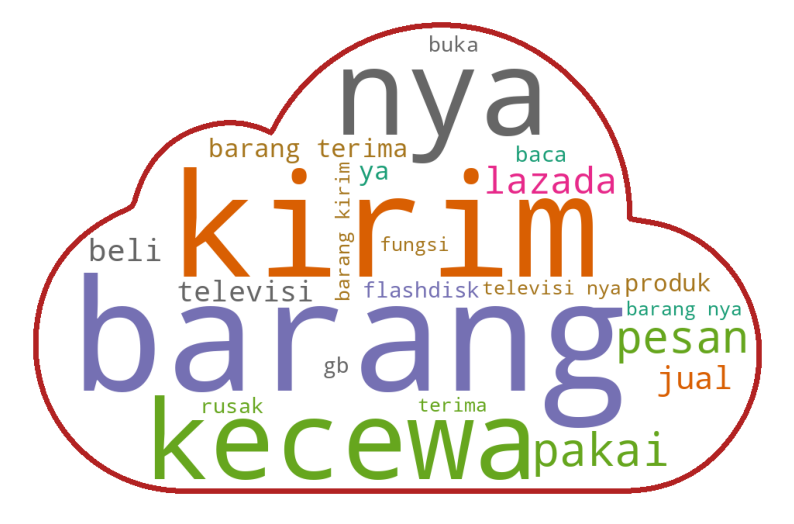

In [68]:
# WordCloud Label Rating 1

rating_satu = df[df.rating == 1]
normal_string = []

for t in rating_satu.reviewContent:
    normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

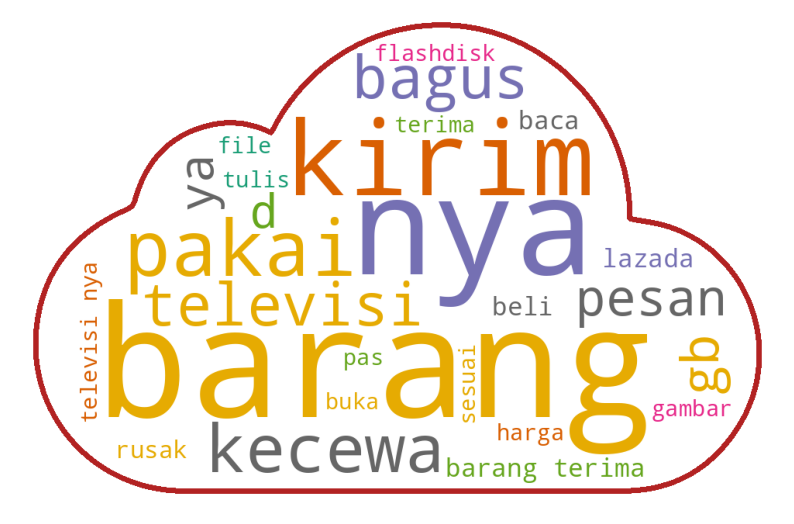

In [69]:
# WordCloud Label Rating 2

rating_dua = df[df.rating == 2]
normal_string = []

for t in rating_dua.reviewContent:
    normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

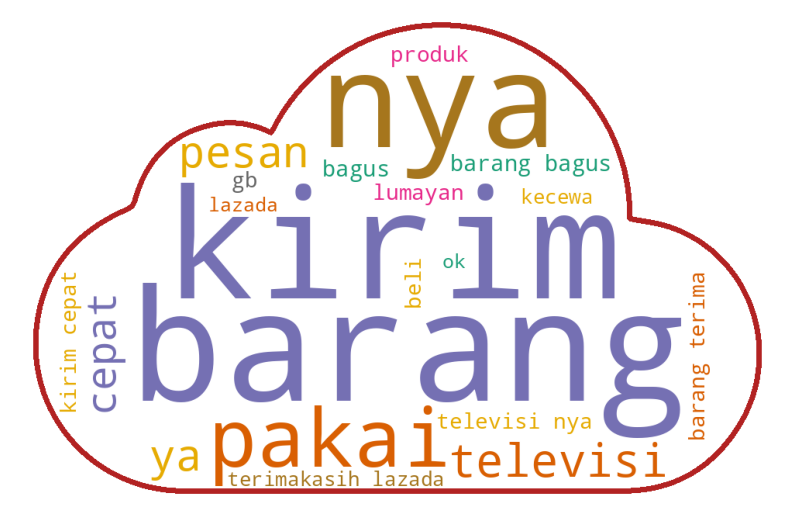

In [70]:
# WordCloud Label Rating 3

rating_tiga = df[df.rating == 3]
normal_string = []

for t in rating_tiga.reviewContent:
    normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

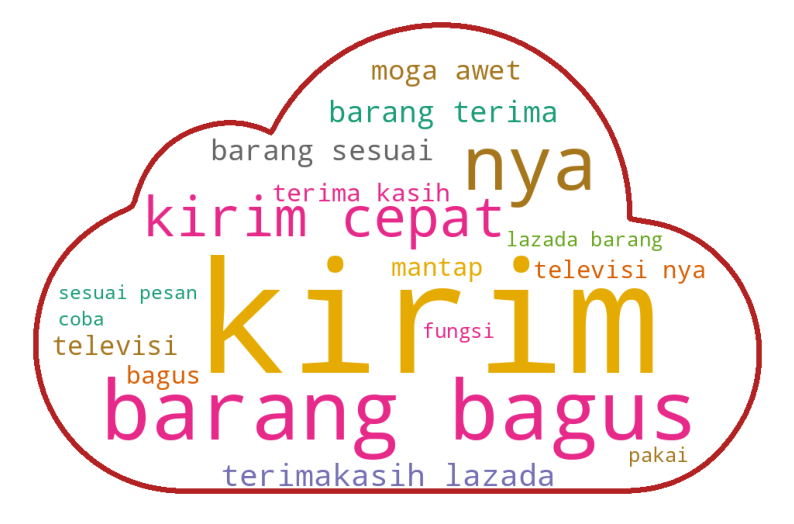

In [71]:
# WordCloud Label Rating 4

rating_empat = df[df.rating == 4]
normal_string = []

for t in rating_empat.reviewContent:
    normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

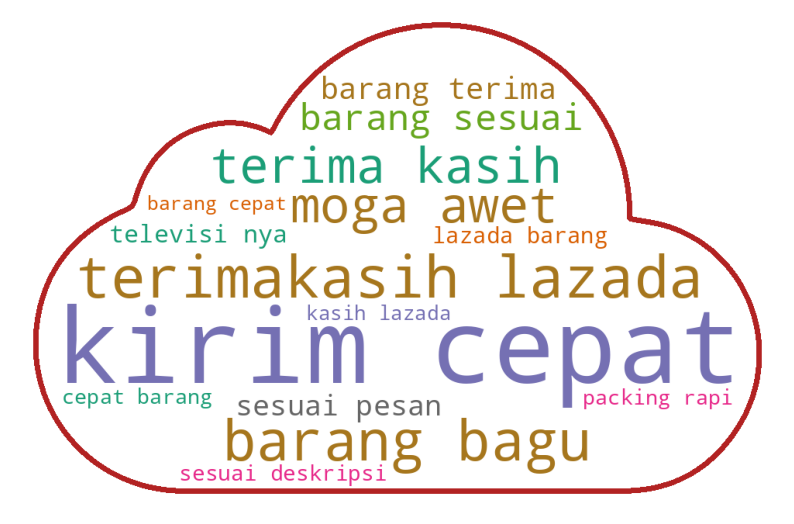

In [72]:
# WordCloud Label Rating 5

rating_lima = df[df.rating == 5]
normal_string = []

for t in rating_lima.reviewContent:
    normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()